This kernel is based on [Theo Viel](https://www.kaggle.com/theoviel/deep-learning-starter) , [Gabriel Preda](https://www.kaggle.com/gpreda/robots-need-help), [Nanashi](https://www.kaggle.com/jesucristo/1-smart-robots-complete-notebook-0-73/notebook) and [Vansh Jatana](https://www.kaggle.com/vanshjatana/help-humanity-by-helping-robots-4e306b/notebook). Here I applied RandomForestClassifier,  set random_state higher and kfold to 50.

In [1]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import itertools
from sklearn.metrics import *

### Load Data

In [2]:
X_train = pd.read_csv("../input/X_train.csv")
X_test = pd.read_csv("../input/X_test.csv")
y_train = pd.read_csv("../input/y_train.csv")
sub = pd.read_csv("../input/sample_submission.csv")

In [3]:
X_train.head()

row_id          ...            linear_acceleration_Z
0    0_0          ...                          -9.7532
1    0_1          ...                          -9.4128
2    0_2          ...                          -8.7267
3    0_3          ...                         -10.0960
4    0_4          ...                         -10.4410

[5 rows x 13 columns]

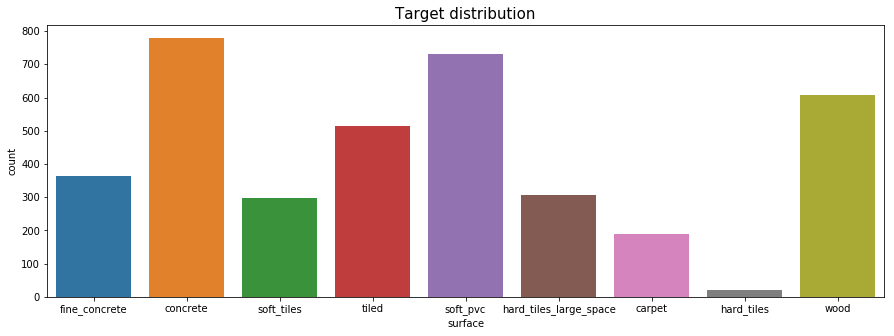

In [4]:
plt.figure(figsize=(15, 5))
sns.countplot(y_train['surface'])
plt.title('Target distribution', size=15)
plt.show()

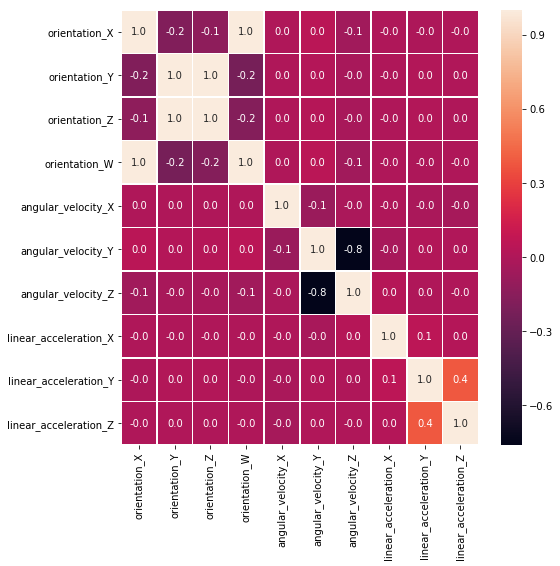

In [5]:
# https://www.kaggle.com/jesucristo/1-smart-robots-complete-notebook-0-73/notebook
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(X_train.iloc[:,3:].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Here we can discover strong correlation between angular_velocity_Z and angular_velocity_Y.


### Feature Engineer

In [6]:
#https://www.kaggle.com/prashantkikani/help-humanity-by-helping-robots

def fe(data):
    
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 +
                             data['angular_velocity_Z']**2)** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 +
                             data['linear_acceleration_Z'])**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 +
                             data['orientation_Z'])**0.5
   
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df


In [7]:
%%time
X_train = fe(X_train)
X_test = fe(X_test)
print(X_train.shape)

(3810, 154)
CPU times: user 1min 20s, sys: 160 ms, total: 1min 20s
Wall time: 1min 20s


In [8]:
X_train.head()

orientation_X_mean         ...          acc_vs_vel_abs_avg
series_id                             ...                            
0                   -0.758666         ...                  176.519784
1                   -0.958606         ...                   93.579492
2                   -0.512057         ...                  134.912654
3                   -0.939169         ...                  218.731376
4                   -0.891301         ...                   13.337724

[5 rows x 154 columns]

### Ouput

We encode our targets

In [9]:
le = LabelEncoder()
y_train['surface'] = le.fit_transform(y_train['surface'])

## Modeling

### $k$-Folds

In [10]:
X_train.fillna(0, inplace = True)
X_test.fillna(0, inplace = True)
X_train.replace(-np.inf, 0, inplace = True)
X_train.replace(np.inf, 0, inplace = True)
X_test.replace(-np.inf, 0, inplace = True)
X_test.replace(np.inf, 0, inplace = True)

In [11]:
def k_folds(X, y, X_test, k):
    folds = StratifiedKFold(n_splits = k, shuffle=True, random_state=2019)
    y_test = np.zeros((X_test.shape[0], 9))
    y_oof = np.zeros((X.shape[0]))
    score = 0
    for i, (train_idx, val_idx) in  enumerate(folds.split(X, y)):
        clf =  RandomForestClassifier(n_estimators = 500, n_jobs = -1)
        clf.fit(X_train.iloc[train_idx], y[train_idx])
        y_oof[val_idx] = clf.predict(X.iloc[val_idx])
        y_test += clf.predict_proba(X_test) / folds.n_splits
        score += clf.score(X.iloc[val_idx], y[val_idx])
        print('Fold: {} score: {}'.format(i,clf.score(X.iloc[val_idx], y[val_idx])))
    print('Avg Accuracy', score / folds.n_splits) 
        
    return y_oof, y_test 

In [12]:
y_oof, y_test = k_folds(X_train, y_train['surface'], X_test, k= 50)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 21 members, which is too few. The minimum number of members in any class cannot be less than n_splits=50.
  % (min_groups, self.n_splits)), Warning)


Fold: 0 score: 0.9382716049382716
Fold: 1 score: 0.875
Fold: 2 score: 0.9135802469135802
Fold: 3 score: 0.9125
Fold: 4 score: 0.8375
Fold: 5 score: 0.8625
Fold: 6 score: 0.9375
Fold: 7 score: 0.9113924050632911
Fold: 8 score: 0.8589743589743589
Fold: 9 score: 0.8607594936708861
Fold: 10 score: 0.9615384615384616
Fold: 11 score: 0.8860759493670886
Fold: 12 score: 0.8607594936708861
Fold: 13 score: 0.8717948717948718
Fold: 14 score: 0.9210526315789473
Fold: 15 score: 0.9078947368421053
Fold: 16 score: 0.8701298701298701
Fold: 17 score: 0.868421052631579
Fold: 18 score: 0.9078947368421053
Fold: 19 score: 0.8961038961038961
Fold: 20 score: 0.922077922077922
Fold: 21 score: 0.922077922077922
Fold: 22 score: 0.8961038961038961
Fold: 23 score: 0.8421052631578947
Fold: 24 score: 0.9090909090909091
Fold: 25 score: 0.8289473684210527
Fold: 26 score: 0.8961038961038961
Fold: 27 score: 0.9210526315789473
Fold: 28 score: 0.9342105263157895
Fold: 29 score: 0.9066666666666666
Fold: 30 score: 0.868421

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_oof,y_train['surface'])

array([[153,   3,   0,   0,   4,   2,   2,   3,   0],
       [ 15, 696,  20,   1,  11,  18,   4,  22,  14],
       [  0,   9, 296,   0,   3,   5,   0,   2,   6],
       [  0,   0,   0,  10,   0,   0,   0,   0,   1],
       [  1,  14,   1,   0, 282,   4,   0,   3,   1],
       [  4,  15,   7,   0,   1, 678,   4,   8,  22],
       [  4,   9,   2,   2,   1,   8, 281,   4,   2],
       [  2,  12,  11,   0,   0,   2,   0, 466,  21],
       [ 10,  21,  26,   8,   6,  15,   6,   6, 540]])

### Submission

In [14]:
y_test = np.argmax(y_test, axis=1)
submission = pd.read_csv(os.path.join("../input/",'sample_submission.csv'))
submission['surface'] = le.inverse_transform(y_test)
submission.to_csv('submission.csv', index=False)
submission.head(10)

series_id                 surface
0          0  hard_tiles_large_space
1          1                concrete
2          2                   tiled
3          3                  carpet
4          4              soft_tiles
5          5                concrete
6          6                concrete
7          7                concrete
8          8                    wood
9          9                    wood

## Reference
[Gabriel Preda](https://www.kaggle.com/gpreda/robots-need-help)  
[Theo Viel](https://www.kaggle.com/theoviel/deep-learning-starter)  
[Nanashi](https://www.kaggle.com/jesucristo/1-smart-robots-complete-notebook-0-73)
##### Please leave an upvote, it is always appreciated!